In [1]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import interpolation as inter

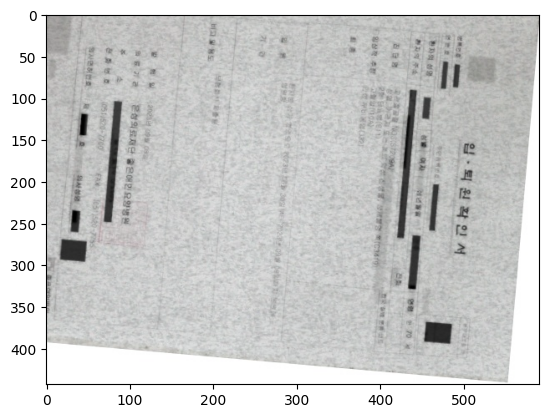

In [2]:
img_path = "/home/pervinco/upstage-cv-classification-cv7/runs/best_9564/incorrect/pred3_gt7_1f40e905a531d54f.jpg"
img = cv2.imread(img_path)

plt.imshow(img)

In [3]:
def display(img, frameName="OpenCV Image"):
    h, w = img.shape[0:2]
    neww = 800
    newh = int(neww*(h/w))
    img = cv2.resize(img, (neww, newh))
    plt.imshow(img)


def rotate(img, theta):
    rows, cols = img.shape[0], img.shape[1]
    image_center = (cols/2, rows/2)
    
    M = cv2.getRotationMatrix2D(image_center,theta,1)

    abs_cos = abs(M[0,0])
    abs_sin = abs(M[0,1])

    bound_w = int(rows * abs_sin + cols * abs_cos)
    bound_h = int(rows * abs_cos + cols * abs_sin)

    M[0, 2] += bound_w/2 - image_center[0]
    M[1, 2] += bound_h/2 - image_center[1]

    rotated = cv2.warpAffine(img,M,(bound_w,bound_h),borderValue=(255,255,255))
    return rotated


def slope(x1, y1, x2, y2):
    if x1 == x2:
        return 0
    slope = (y2-y1)/(x2-x1)
    theta = np.rad2deg(np.arctan(slope))
    return theta

Image orientation in degress:  -53.80331576917638


/tmp/ipykernel_2111283/2126216352.py:33: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


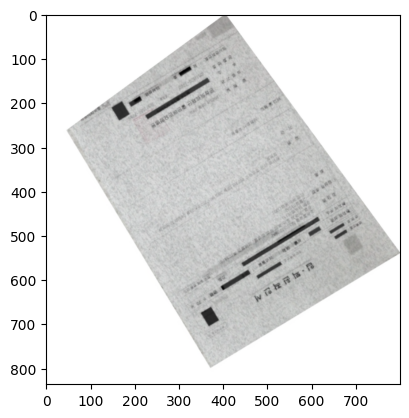

In [4]:
textImg = img.copy()

small = cv2.cvtColor(textImg, cv2.COLOR_BGR2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

display(grad)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
display(bw)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
display(connected)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



cummTheta = 0
mask = np.zeros(bw.shape, dtype=np.uint8)
ct = 0
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    if r > 0.45 and w > 8 and h > 8:
        rect = cv2.minAreaRect(contours[idx])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(textImg,[box],0,(0,0,255),2)

        theta = slope(box[0][0], box[0][1], box[1][0], box[1][1])
        cummTheta += theta
        ct +=1 
        
orientation = cummTheta/ct
print("Image orientation in degress: ", orientation)
finalImage = rotate(img, orientation)
display(textImg, "Detectd Text minimum bounding box")
display(finalImage, "Deskewed Image")

In [5]:
def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[0]:
            angle = theta * 180 / np.pi - 90
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

True

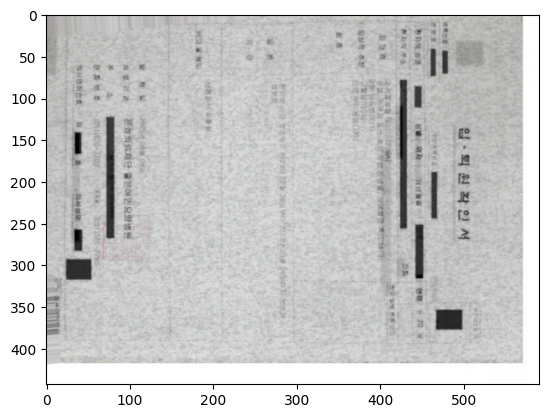

In [6]:
deskewed = deskew(img)

plt.imshow(deskewed)

cv2.imwrite("./deskewed.jpg", deskewed)